# Deep Learning: Mastering Neural Networks - Module 4 Asignment: CNN Classification of FashionMNIST Dataset

Now that we have Convolutional layers in our deep learning toolkit, we are going tackle a new and more challenging dataset - the [FashionMNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist) dataset. This dataset is in a similar format to the MNIST dataset, however it contains images of different articles of clothing.

In this assignment, we ask that you develop a CNN classifier that implements **at least 2** convolutional layers.

A template has been provided below with some starter code and please feel free to reuse any code you have written or seen before in previous notebooks!



In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.nn.modules.flatten import Flatten
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# Notice how FashionMNIST is also built into PyTorch!
fashion_mnist_train = torchvision.datasets.FashionMNIST('', train=True, transform =transform, download=True)

# We will split out train dataset into train and validation!
fashion_mnist_train, fashion_mnist_val = torch.utils.data.random_split(fashion_mnist_train, [int(np.floor(len(fashion_mnist_train)*0.75)), int(np.ceil(len(fashion_mnist_train)*0.25))])

fashion_mnist_test = torchvision.datasets.FashionMNIST('', train=False, transform = transform, download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.64MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 166kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.19MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.9MB/s]


In [3]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(fashion_mnist_train, batch_size=batch_size),
               'val': DataLoader(fashion_mnist_val, batch_size=batch_size),
               'test': DataLoader(fashion_mnist_test, shuffle=True, batch_size=batch_size)}

dataset_sizes = {'train': len(fashion_mnist_train),
                 'val': len(fashion_mnist_val),
                 'test': len(fashion_mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 45000, 'val': 15000, 'test': 10000}


## Visualization

Before we go any further, we want to visualize the different datapoints in our dataset. Similar to the MNIST datset, there are 10 different object classes and they map to the following labels:

* 0 - T-shirt/top
* 1 - Trouser
* 2 - Pullover
* 3 - Dress
* 4 - Coat
* 5 - Sandal
* 6 - Shirt
* 7 - Sneaker
* 8 - Bag
* 9 - Ankle boot

Using the function below, we can visualize some of the different images that we will be working with from each class. Additionally, follow this [link](https://www.kaggle.com/datasets/zalando-research/fashionmnist) to find more information on the dataset.

In [4]:
# plot a digit ground truth and autoencoding
def view_fashionmnist(label, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        for i, input in enumerate(inputs):
            # we only want to view a certain class
            if (labels[i] != label):
                continue
            # plot the ground truth
            ax = fig.add_subplot(1, count, idx)
            input = input.cpu().detach().numpy().reshape((28,28))
            ax.imshow(input, cmap='gray')
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

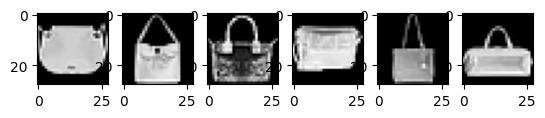

In [5]:
# View 6 bags
view_fashionmnist(8, 6)

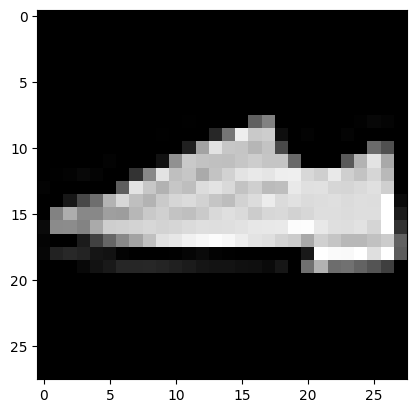

In [6]:
# View 1 sneaker
view_fashionmnist(7, 1)

## Your Turn

Use what you have learned so far to develop a CNN classifier that implements **at least 2** convolutional layers.

In [7]:
# Hint! Create a CNNClassifier class that implements a forward function
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        # Split the Encoder and Decoder

        self.pipeline = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 24, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            # add 2nd conv layer
            nn.Conv2d(in_channels = 24, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Flatten(),
            nn.Linear(32*7*7, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.pipeline(x)


In [8]:
learning_rate = 0.001
num_epochs = 10

model = CNNClassifier().to(device)
print(model)

CNNClassifier(
  (pipeline): Sequential(
    (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1568, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [9]:
# Hint! Try reusing one of the training functions we have previously written
def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # No need to flatten the inputs!
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (bas
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves

In [10]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Make sure you save the training curves along the way for visualization afterwards!
model, training_curves = train_classification_model(model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.5509 Acc: 0.8010
val   Loss: 0.4076 Acc: 0.8497
test  Loss: 0.4263 Acc: 0.8418

Epoch 2/10
----------
train Loss: 0.3570 Acc: 0.8716
val   Loss: 0.3248 Acc: 0.8820
test  Loss: 0.3452 Acc: 0.8741

Epoch 3/10
----------
train Loss: 0.3091 Acc: 0.8888
val   Loss: 0.2925 Acc: 0.8933
test  Loss: 0.3127 Acc: 0.8848

Epoch 4/10
----------
train Loss: 0.2784 Acc: 0.8992
val   Loss: 0.2713 Acc: 0.9027
test  Loss: 0.2913 Acc: 0.8947

Epoch 5/10
----------
train Loss: 0.2551 Acc: 0.9075
val   Loss: 0.2604 Acc: 0.9065
test  Loss: 0.2796 Acc: 0.8984

Epoch 6/10
----------
train Loss: 0.2362 Acc: 0.9141
val   Loss: 0.2548 Acc: 0.9085
test  Loss: 0.2721 Acc: 0.9025

Epoch 7/10
----------
train Loss: 0.2200 Acc: 0.9199
val   Loss: 0.2502 Acc: 0.9130
test  Loss: 0.2653 Acc: 0.9050

Epoch 8/10
----------
train Loss: 0.2052 Acc: 0.9254
val   Loss: 0.2459 Acc: 0.9138
test  Loss: 0.2607 Acc: 0.9083

Epoch 9/10
----------
train Loss: 0.1920 Acc: 0.9304
val   Loss: 0.2454

### Visualizing Training Curves and Results

In [11]:
# Utility functions for plotting your results!
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


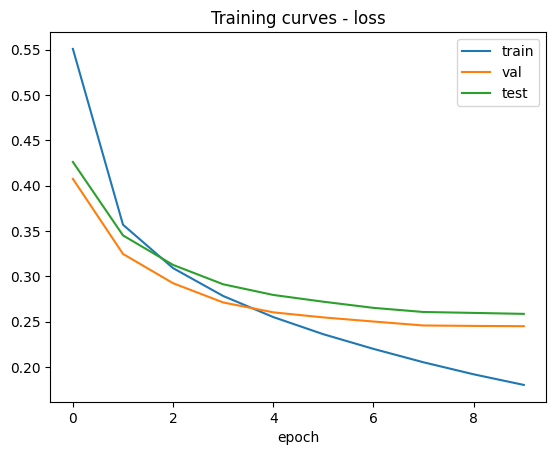

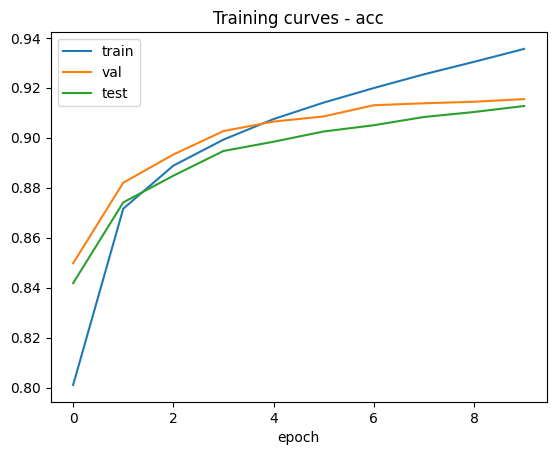

In [12]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

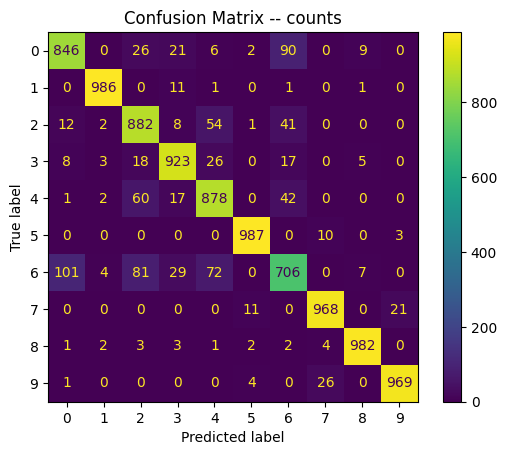

In [13]:
res = plot_cm(model, device, dataloaders, phase='test')

## Conclusions

Now that we have implemented our network we want to examine the results.

What class of object is most often misclassified? What class is it incorrectly classified as most often?

Additionally, try re-training your network with dropout included. Does this help the performance or is there a noticeable change in the ability of the model to generalize? Is the most commonly misclassified object still the same as with no dropout?